## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Ti


## 2. Load Processed Dataset

In [2]:
# Load processed data
data_path = Path(r'c:\Users\Tplab\OneDrive\CNN tutorial\data\processed')
df = pd.read_csv(data_path / 'bot_iot_processed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"\nColumns: {df.columns.tolist()}")

Dataset shape: (20000000, 31)
Memory usage: 6.29 GB

Columns: ['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack', 'category', 'subcategory', 'category_encoded', 'subcategory_encoded']
Memory usage: 6.29 GB

Columns: ['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack', 'category', 'subcategory', 'category_encoded', 'subcategory_encoded']


In [3]:
# Check data info
print("\nAttack distribution:")
print(df['attack'].value_counts())
print(f"\nAttack ratio: {df['attack'].value_counts(normalize=True)*100}")


Attack distribution:
attack
1    19992447
0        7553
Name: count, dtype: int64

Attack ratio: attack
1    99.962235
0     0.037765
Name: proportion, dtype: float64


## 3. Prepare Data for CNN

In [4]:
# Chọn features và target
# Bỏ các cột không dùng cho training
exclude_cols = ['attack', 'category', 'subcategory', 'category_encoded', 'subcategory_encoded']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare X and y
X = df[feature_cols].values
y = df['attack'].values  # Binary classification: 0=Normal, 1=Attack

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y unique values: {np.unique(y)}")

Number of features: 26
Features: ['pkSeqID', 'stime', 'flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate']

X shape: (20000000, 26)
y shape: (20000000,)
y unique values: [0 1]

X shape: (20000000, 26)
y shape: (20000000,)
y unique values: [0 1]


In [5]:
# Train/Validation/Test split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Giải phóng memory
del X, y, df
import gc
gc.collect()

Train set: 14,000,000 samples (70.0%)
Val set:   3,000,000 samples (15.0%)
Test set:  3,000,000 samples (15.0%)


0

In [6]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Data standardization completed!")
print(f"Train mean: {X_train.mean():.6f}, std: {X_train.std():.6f}")
print(f"Val mean:   {X_val.mean():.6f}, std: {X_val.std():.6f}")
print(f"Test mean:  {X_test.mean():.6f}, std: {X_test.std():.6f}")

Data standardization completed!
Train mean: -0.000000, std: 1.000000
Train mean: -0.000000, std: 1.000000
Val mean:   -0.000161, std: 0.956686
Val mean:   -0.000161, std: 0.956686
Test mean:  -0.000016, std: 1.051510
Test mean:  -0.000016, std: 1.051510


In [7]:
# Save scaler for later use
scaler_path = Path(r'c:\Users\Tplab\OneDrive\CNN tutorial\data\processed')
with open(scaler_path / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved!")

Scaler saved!


In [8]:
# Reshape for CNN: (batch_size, channels, sequence_length)
# Treat each feature as a time step -> (N, 1, num_features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Reshaped for CNN:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")

Reshaped for CNN:
X_train shape: (14000000, 1, 26)
X_val shape:   (3000000, 1, 26)
X_test shape:  (3000000, 1, 26)


In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print("Converted to PyTorch tensors!")

Converted to PyTorch tensors!


In [10]:
# Create DataLoaders
batch_size = 512

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Batch size: 512
Train batches: 27344
Val batches:   5860
Test batches:  5860


## 4. Build CNN Model

In [11]:
class DDoSCNN(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(DDoSCNN, self).__init__()
        
        # Conv layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Calculate flattened size
        # input_size -> pool1 -> pool2 -> pool3
        self.flattened_size = 256 * (input_size // 8)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        
        x = self.fc2(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        
        x = self.fc3(x)
        
        return x

print("CNN Model class defined!")

CNN Model class defined!


In [12]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

input_size = X_train.shape[2]  # Number of features
model = DDoSCNN(input_size=input_size, num_classes=2)
model = model.to(device)

print(f"\nModel initialized with input size: {input_size}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda

Model initialized with input size: 26
Model parameters: 231,618


In [13]:
# Model summary
print("\nModel Architecture:")
print("="*60)
print(model)
print("="*60)


Model Architecture:
DDoSCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=768, out_featu

## 5. Training Setup

In [14]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print("Training setup complete!")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Scheduler: ReduceLROnPlateau")

Training setup complete!
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


In [15]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Print progress
        if (batch_idx + 1) % 100 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Training function defined!")

Training function defined!


In [16]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Validation function defined!")

Validation function defined!


## 6. Train Model

In [17]:
# Training loop
num_epochs = 20
best_val_acc = 0.0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {num_epochs} epochs...\n")
print("="*70)

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print("-"*70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print epoch results
    print(f"\n  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_path = Path(r'c:\Users\Tplab\OneDrive\CNN tutorial\models')
        model_path.mkdir(exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, model_path / 'best_cnn_model.pth')
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*70)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training for 20 epochs...


Epoch [1/20]
----------------------------------------------------------------------
  Batch [100/27344], Loss: 0.0519, Acc: 92.18%
  Batch [100/27344], Loss: 0.0519, Acc: 92.18%
  Batch [200/27344], Loss: 0.0168, Acc: 96.06%
  Batch [200/27344], Loss: 0.0168, Acc: 96.06%
  Batch [300/27344], Loss: 0.0092, Acc: 97.36%
  Batch [300/27344], Loss: 0.0092, Acc: 97.36%
  Batch [400/27344], Loss: 0.0049, Acc: 98.01%
  Batch [400/27344], Loss: 0.0049, Acc: 98.01%
  Batch [500/27344], Loss: 0.0107, Acc: 98.40%
  Batch [500/27344], Loss: 0.0107, Acc: 98.40%
  Batch [600/27344], Loss: 0.0029, Acc: 98.67%
  Batch [600/27344], Loss: 0.0029, Acc: 98.67%
  Batch [700/27344], Loss: 0.0023, Acc: 98.85%
  Batch [700/27344], Loss: 0.0023, Acc: 98.85%
  Batch [800/27344], Loss: 0.0024, Acc: 98.99%
  Batch [800/27344], Loss: 0.0024, Acc: 98.99%
  Batch [900/27344], Loss: 0.0015, Acc: 99.10%
  Batch [900/27344], Loss: 0.0015, Acc: 99.10%
  Batch [1000/27344], Loss: 0.001

## 7. Visualize Training History

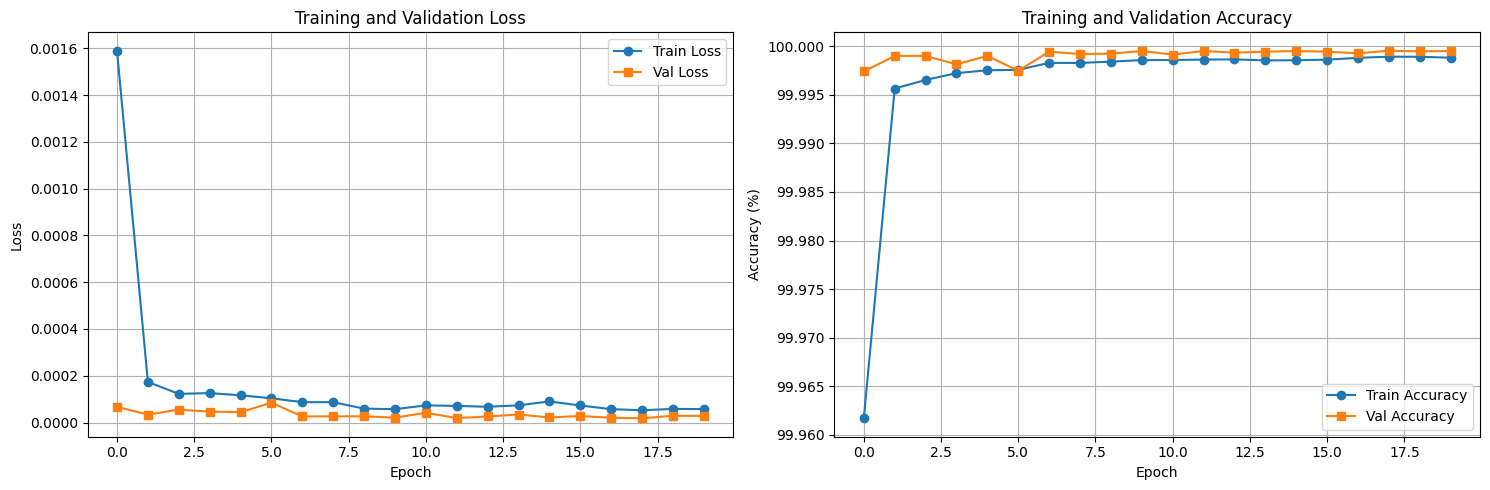

Training history plot saved!


In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(val_accs, label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(r'c:\Users\Tplab\OneDrive\CNN tutorial\results\training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved!")

## 8. Evaluate on Test Set

In [19]:
# Load best model
model_path = Path(r'c:\Users\Tplab\OneDrive\CNN tutorial\models')
checkpoint = torch.load(model_path / 'best_cnn_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")

Loaded best model from epoch 18
Validation accuracy: 100.00%


In [20]:
# Test evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Test evaluation completed!")

Test evaluation completed!


In [21]:
# Classification metrics
test_acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print("="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Accuracy:  {test_acc*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")
print("="*60)

TEST SET RESULTS
Accuracy:  100.00%
Precision: 100.00%
Recall:    100.00%
F1-Score:  100.00%


In [22]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("-"*60)
target_names = ['Normal (0)', 'Attack (1)']
print(classification_report(y_true, y_pred, target_names=target_names))


Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      0.99      1133
  Attack (1)       1.00      1.00      1.00   2998867

    accuracy                           1.00   3000000
   macro avg       1.00      1.00      1.00   3000000
weighted avg       1.00      1.00      1.00   3000000

              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      0.99      1133
  Attack (1)       1.00      1.00      1.00   2998867

    accuracy                           1.00   3000000
   macro avg       1.00      1.00      1.00   3000000
weighted avg       1.00      1.00      1.00   3000000



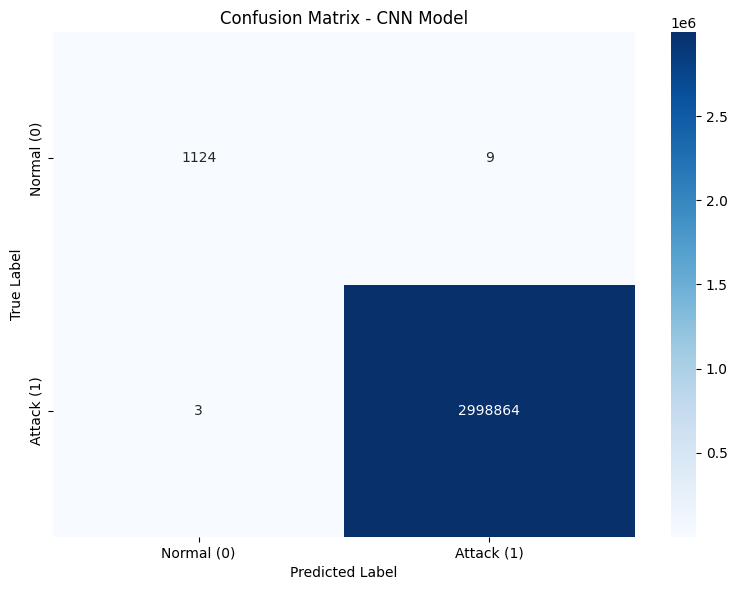

Confusion matrix plot saved!


In [23]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(r'c:\Users\Tplab\OneDrive\CNN tutorial\results\confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix plot saved!")

## 9. Save Final Results

In [24]:
# Save results to file
results_path = Path(r'c:\Users\Tplab\OneDrive\CNN tutorial\results')
results_path.mkdir(exist_ok=True)

results = {
    'model': 'CNN',
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'best_val_acc': best_val_acc,
    'test_accuracy': test_acc * 100,
    'test_precision': precision * 100,
    'test_recall': recall * 100,
    'test_f1': f1 * 100,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs
}

with open(results_path / 'cnn_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved successfully!")
print(f"\nFinal Test Metrics:")
print(f"  Accuracy:  {test_acc*100:.2f}%")
print(f"  Precision: {precision*100:.2f}%")
print(f"  Recall:    {recall*100:.2f}%")
print(f"  F1-Score:  {f1*100:.2f}%")

Results saved successfully!

Final Test Metrics:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%


In [25]:
print("\n" + "="*60)
print("CNN MODEL TRAINING COMPLETED!")
print("="*60)
print(f"Best model saved to: {model_path / 'best_cnn_model.pth'}")
print(f"Results saved to: {results_path / 'cnn_results.pkl'}")
print(f"Plots saved to: {results_path}")
print("="*60)


CNN MODEL TRAINING COMPLETED!
Best model saved to: c:\Users\Tplab\OneDrive\CNN tutorial\models\best_cnn_model.pth
Results saved to: c:\Users\Tplab\OneDrive\CNN tutorial\results\cnn_results.pkl
Plots saved to: c:\Users\Tplab\OneDrive\CNN tutorial\results
